<div id="toc"> </div>

# Import lots of stuff

In [1]:
import itertools
import math
import re
import csv
import re;
import json
import os
import pandas as pd
import pylab as pyl
import nltk as nltk
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from pycorenlp import StanfordCoreNLP
%matplotlib inline
#enable longer display
pd.set_option('display.max_rows', 500)

# Preprocess data for analyses

## Import annotated file

In [8]:
d_raw = pd.read_csv('../data/tangramsSequential.csv')
d = d_raw.copy()
# Drop time column
# d = (d_raw
#     .copy()
#     .drop('time', 1)
#     .query('tangramRef != "0"'))

# Result 1: Generate file for POS analysis

## Start the Stanford CoreNLP server

Before running this notebook, [get CoreNLP](http://nlp.stanford.edu/software/stanford-corenlp-full-2015-12-09.zip), go into its directory, and run

`java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer 9000`

If you're using port 9000 for something else, change that value and then change `PORT` in the next cell.

In [23]:
PORT = 9000

nlp = StanfordCoreNLP('http://localhost:{}'.format(PORT))

## Get part of speech

Todo: follow Will's advice to parse unicode...

In [24]:
def stanford_pos(text):
    """
    Parameters
    ----------
    text : str
       CoreNLP handles all tokenizing, at the sentence and word level.
       
    Returns
    -------
    list of tuples (str, str)
       The first member of each pair is the word, the second its POS tag.          
    """
    try:
        ann = nlp.annotate(
            text, 
            properties={'annotators': 'pos', 
                        'outputFormat': 'json'})
        lemmas = []
        for sentence in ann['sentences']:
            for token in sentence['tokens']:
                lemmas.append((token['word'], token['pos']))
    except Exception as e:
        print(text + ": cannot parse")
        lemmas = []
    return lemmas

In [69]:
from nltk.tree import Tree
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
        print(subtree)
        yield subtree.leaves()
        
def stanford_parsetree(text):
    """
    Parameters
    ----------
    text : str
       CoreNLP handles all tokenizing, at the sentence and word level.
       
    Returns
    -------
    list of tuples (str, str)
       The first member of each pair is the word, the second its POS tag.          
    """
    try:
        ann = nlp.annotate(
            text, 
            properties={'annotators': 'parse', 
                        'outputFormat': 'json'})
        lemmas = []
        for sentence in ann['sentences']:
            lemmas.append(sentence['parse'])
#             nps = leaves(tree)
#             for np in nps:
#                print(np)
    #            print([p in tree.productions() if p.])

    #             for element in sentence['enhancedPlusPlusDependencies']:
    #                 lemmas.append(element)
    except Exception as e:
        print(text,": cannot parse")
        lemmas = []
    return lemmas

In [71]:
stanford_parsetree('fluffy dog with the bow')

['(ROOT\n  (NP\n    (NP (JJ fluffy) (NN dog))\n    (PP (IN with)\n      (NP (DT the) (NN bow)))))']

In [26]:
from nltk.stem.wordnet import WordNetLemmatizer

LEMMATIZER = WordNetLemmatizer()

def is_comp_sup(word, pos, tags, check_lemmatizer=False):
    """
    Parameters
    ----------
    word, pos : str, str
        The lemma.
    
    tags : iterable of str
        The tags considered positive evidence for comp/sup morphology.
       
       
    check_lemmatizer : bool
        If True, then if the `pos` is in `tags`, we also check that
        `word` is different from the lemmatized version of word
        according to WordNet, treating it as an adjective. This 
        could be used to achieve greater precision, perhaps at the
        expense of recall.
       
    Returns
    -------
    bool       
    """
    if pos not in tags:
        return False
    if check_lemmatizer and LEMMATIZER.lemmatize(word, 'a') == word:
        return False
    return True

def is_noun(word, pos, check_lemmatizer=False):
    return is_comp_sup(
        word, pos, {'NN', 'NNS', 'NNP', 'NNPS'}, check_lemmatizer=check_lemmatizer)

def is_prep(word, pos, check_lemmatizer=False):
    return is_comp_sup(
        word, pos, {'IN'}, check_lemmatizer=check_lemmatizer)

def is_verb(word, pos, check_lemmatizer=False):
    return is_comp_sup(
        word, pos, {'MD', 'VB', 'VBZ', 'VBP', 'VBD', 'VBN', 'VBG'}, check_lemmatizer=check_lemmatizer)

def is_det(word, pos, check_lemmatizer=False):
    return is_comp_sup(
        word, pos, {'DT', 'WDT'}, check_lemmatizer=check_lemmatizer)

def is_pronoun(word, pos, check_lemmatizer=False):
    return is_comp_sup(
        word, pos, {'PRP', 'PRP$', 'WP', 'WP$'}, check_lemmatizer=check_lemmatizer)

def is_adjective(word, pos, check_lemmatizer=False):
    return is_comp_sup(
        word, pos, {'JJ', 'JJR', 'JJS'}, check_lemmatizer=check_lemmatizer)

def is_adverb(word, pos, check_lemmatizer=False):
    return is_comp_sup(
        word, pos, {'RB', 'RBR', 'RBS', 'RP', 'WRB'}, check_lemmatizer=check_lemmatizer)

def is_num(word, pos, check_lemmatizer=False):
    return is_comp_sup(
        word, pos, {'CD'}, check_lemmatizer=check_lemmatizer)

def is_other(word, pos, check_lemmatizer=False):
    return is_comp_sup(
        word, pos, {'EX', 'FW', 'LS', 'PDT', 'POS', 'SYM', 'TO', 'UH'}, check_lemmatizer=check_lemmatizer)

def is_compound(tags) :
    dependentClauseTags = {'csubj', 'ccomp', 'xcomp', 'advcl'}
    return sum([tag in dependentClauseTags for tag in tags]) > 0

def is_adjectival(tags)  :
    return sum([tag in {'acl', 'acl:relcl'} for tag in tags]) > 0

In [9]:
# A lemma is a (word, pos) tag pair.
d['lemmas'] = [stanford_pos(text) for text in d['contents']]

In [10]:
d['tokens'] = [[element[0] for element in l] for l in d['lemmas']]
d['pos'] = [[element[1] for element in l] for l in d['lemmas']]

In [11]:
d['numWords'] = [pd.value_counts(words).sum() for words in d['tokens']]

In [73]:
d['parse'] = [[w for w in stanford_parsetree(text)] for text in d['contents']]

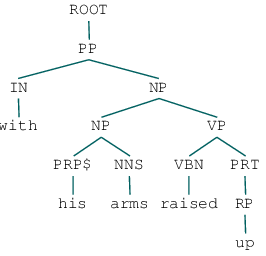

In [112]:
Tree.fromstring(d['parse'][8][0])
# for p in leaves() :
#     print(p)
#d['np_text'] = 

In [111]:
d['clauses'] = [is_compound(tags) for tags in d['tags']]
d['acl'] = [is_adjectival(tags) for tags in d['tags']]

## Get counts for each POS label

In [112]:
d['nouns'] = [sum([1 if is_noun(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['prepositions'] = [sum([1 if is_prep(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['verbs'] = [sum([1 if is_verb(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['determiners'] = [sum([1 if is_det(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['pronouns'] = [sum([1 if is_pronoun(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['adjectives'] = [sum([1 if is_adjective(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['adverbs'] = [sum([1 if is_adverb(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['numbers'] = [sum([1 if is_num(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['others'] = [sum([1 if is_other(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]

In [117]:
d

,gameid,roundNum,sender,contents,tangramRef,lemmas,tokens,pos,numWords,clauses,...,prepositions,verbs,determiners,pronouns,adjectives,adverbs,numbers,others,tags,acl
2,0955-2,1,director,number 1 is a guy that looks like he is prayin...,L,"[(number, NN), (1, CD), (is, VBZ), (a, DT), (g...","[number, 1, is, a, guy, that, looks, like, he,...","[NN, CD, VBZ, DT, NN, WDT, VBZ, IN, PRP, VBZ, ...",17,False,...,2,4,4,1,0,0,1,1,"[ROOT, nsubj, nummod, cop, det, nsubj, ref, ac...",True
4,0955-2,1,director,number 2 is a man who looks like he's standing...,A,"[(number, NN), (2, CD), (is, VBZ), (a, DT), (m...","[number, 2, is, a, man, who, looks, like, he, ...","[NN, CD, VBZ, DT, NN, WP, VBZ, IN, PRP, VBZ, V...",26,False,...,4,4,4,3,0,0,2,1,"[ROOT, nsubj, nummod, cop, det, nsubj, ref, ac...",True
6,0955-2,1,director,number 3 is a man with his hands in the air lo...,C,"[(number, NN), (3, CD), (is, VBZ), (a, DT), (m...","[number, 3, is, a, man, with, his, hands, in, ...","[NN, CD, VBZ, DT, NN, IN, PRP$, NNS, IN, DT, N...",16,False,...,3,4,2,2,0,0,1,0,"[ROOT, nsubj, nummod, cop, det, case, nmod:pos...",True
7,0955-2,1,director,number 4 i sa man with his foot parallel to th...,I,"[(number, NN), (4, CD), (i, FW), (sa, FW), (ma...","[number, 4, i, sa, man, with, his, foot, paral...","[NN, CD, FW, FW, NN, IN, PRP$, NN, NN, TO, DT,...",21,False,...,2,0,3,2,0,0,1,4,"[ROOT, nummod, amod, compound, dep, case, nmod...",False
8,0955-2,1,director,number 5 is a person on ground that doesn't lo...,G,"[(number, NN), (5, CD), (is, VBZ), (a, DT), (p...","[number, 5, is, a, person, on, ground, that, d...","[NN, CD, VBZ, DT, NN, IN, NN, WDT, VBZ, RB, VB...",14,False,...,2,3,3,0,0,1,1,0,"[ROOT, nsubj, nummod, cop, det, nsubj, case, n...",True
9,0955-2,1,director,number 6 looks similar but with big pointy boobs,B,"[(number, NN), (6, CD), (looks, VBZ), (similar...","[number, 6, looks, similar, but, with, big, po...","[NN, CD, VBZ, JJ, CC, IN, JJ, JJ, NNS]",9,True,...,1,1,0,0,3,0,1,0,"[ROOT, nsubj, nummod, xcomp, cc, case, amod, c...",False
10,0955-2,1,director,number 7 looks like a person praying,D,"[(number, NN), (7, CD), (looks, VBZ), (like, I...","[number, 7, looks, like, a, person, praying]","[NN, CD, VBZ, IN, DT, NN, VBG]",7,False,...,1,2,1,0,0,0,1,0,"[ROOT, nsubj, nummod, case, det, nmod:like, acl]",True
11,0955-2,1,director,number 8 looks like a blob with no arms,H,"[(number, NN), (8, CD), (looks, VBZ), (like, I...","[number, 8, looks, like, a, blob, with, no, arms]","[NN, CD, VBZ, IN, DT, NN, IN, DT, NNS]",9,False,...,2,1,2,0,0,0,1,0,"[ROOT, nummod, dep, case, det, nmod:like, case...",False
12,0955-2,1,director,number 9 looks like a rabbit sitting on the groud,E,"[(number, NN), (9, CD), (looks, VBZ), (like, I...","[number, 9, looks, like, a, rabbit, sitting, o...","[NN, CD, VBZ, IN, DT, NN, VBG, IN, DT, NN]",10,False,...,2,2,2,0,0,0,1,0,"[ROOT, nsubj, nummod, case, det, nmod:like, ac...",True
13,0955-2,1,director,number 10 looks like a woman praying with her ...,K,"[(number, NN), (10, CD), (looks, VBZ), (like, ...","[number, 10, looks, like, a, woman, praying, w...","[NN, CD, VBZ, IN, DT, NN, VBG, IN, PRP$, NNS, ...",13,False,...,2,2,2,1,0,0,1,1,"[ROOT, nsubj, nummod, case, det, nmod:like, ac...",True


## Export to csv for plotting in R

In [116]:
(d.drop(["lemmas", "contents", "tokens"], 1)
 .to_csv("posTagged.csv", index = False))

# Result 2: Calculate indicator words for tangrams/rounds

## First, get list of words in first round

In [98]:
d_round1

,gameid,msgTime,roundNum,occurrenceNum,role,intendedName,timeElapsed,contents,totalLength,thinksHuman,...,intendedObj,clickedObj,objBox,correct,numRawWords,lemmas,tokens,pos,numWords,parse
0,7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b,1.490375e+12,1,1,director,B,6036,"Hello, I am going to describe them as people a...",1309306.0,yes,...,B,B,12,1,10,"[(Hello, UH), (,, ,), (I, PRP), (am, VBP), (go...","[Hello, ,, I, am, going, to, describe, them, a...","[UH, ,, PRP, VBP, VBG, TO, VB, PRP, IN, NNS, R...",12,"[(ROOT\n (S\n (INTJ (UH Hello))\n (, ,)..."
1,7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b,1.490375e+12,1,1,director,B,1344,Is that okay?,1309306.0,yes,...,B,B,12,1,3,"[(Is, VBZ), (that, IN), (okay, JJ), (?, .)]","[Is, that, okay, ?]","[VBZ, IN, JJ, .]",4,[(ROOT\n (SQ (VBZ Is)\n (NP (DT that))\n ...
2,7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b,1.490375e+12,1,1,matcher,B,194,yes,1105669.0,yes,...,B,B,12,1,1,"[(yes, RB)]",[yes],[RB],1,[(ROOT\n (INTJ (UH yes)))]
3,7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b,1.490375e+12,1,1,director,B,11538,This one kinda looks like they are looking a l...,1309306.0,yes,...,B,B,12,1,17,"[(This, DT), (one, CD), (kinda, NN), (looks, V...","[This, one, kinda, looks, like, they, are, loo...","[DT, CD, NN, VBZ, IN, PRP, VBP, VBG, DT, RB, R...",17,[(ROOT\n (S\n (NP (DT This) (CD one) (NN k...
4,7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b,1.490375e+12,1,1,director,B,4642,wearing a dress maybe.,1309306.0,yes,...,B,B,12,1,4,"[(wearing, VBG), (a, DT), (dress, NN), (maybe,...","[wearing, a, dress, maybe, .]","[VBG, DT, NN, RB, .]",5,[(ROOT\n (S\n (VP (VBG wearing)\n (NP...
108,1567-e80221b4-f349-4b3b-9921-224ee47eea1f,1.490375e+12,1,1,matcher,A,729,Hi,1843446.0,yes,...,A,A,8,1,1,"[(Hi, NN)]",[Hi],[NN],1,[(ROOT\n (NP (NNP Hi)))]
109,1567-e80221b4-f349-4b3b-9921-224ee47eea1f,1.490375e+12,1,1,director,A,10206,looks sad with his head down kicking rocks,NaN,NaN,...,A,A,8,1,8,"[(looks, VBZ), (sad, JJ), (with, IN), (his, PR...","[looks, sad, with, his, head, down, kicking, r...","[VBZ, JJ, IN, PRP$, NN, IN, VBG, NNS]",8,[(ROOT\n (S\n (NP (NNS looks))\n (ADJP ...
110,1567-e80221b4-f349-4b3b-9921-224ee47eea1f,1.490375e+12,1,1,director,A,1862,hello :),NaN,NaN,...,A,A,8,1,2,"[(hello, UH), (:, :), (-RRB-, -RRB-)]","[hello, :, -RRB-]","[UH, :, -RRB-]",3,[(ROOT\n (NP\n (NP (NNP hello))\n (: :)...
206,1670-7a1fc24b-6599-4efb-8a98-22ce7368261a,1.490379e+12,1,1,matcher,D,1070,hello,2175997.0,yes,...,D,D,4,1,1,"[(hello, UH)]",[hello],[UH],1,[(ROOT\n (INTJ (UH hello)))]
207,1670-7a1fc24b-6599-4efb-8a98-22ce7368261a,1.490379e+12,1,1,director,D,7403,A diamond is at the top,2357012.0,yes,...,D,D,4,1,6,"[(A, DT), (diamond, NN), (is, VBZ), (at, IN), ...","[A, diamond, is, at, the, top]","[DT, NN, VBZ, IN, DT, NN]",6,[(ROOT\n (S\n (NP (DT A) (NN diamond))\n ...


In [105]:
# Filter down to first round
d_round1 = d[d['occurrenceNum'] == 1]

# Pull out all tokens and collapse into count dict
tokenDict = Counter([item for sublist in d_round1['tokens'].tolist()
                     for item in sublist])
# Pull out all words that occur more than once
wordList = [word for (word,count) in tokenDict.items() if count > 1 and not word.isdigit()]
print(wordList[0:10])
print(len(wordList))

# Get POS map; will be longer because it doesn't require count > 1, but it doesn't matter
POSdict = {word: POS for lemma in d_round1['lemmas'] for (word, POS) in lemma}
print(len(POSdict.keys()))

['Hello', ',', 'I', 'am', 'going', 'to', 'describe', 'them', 'as', 'people']
870
1776


## Get list of all game ids

In [107]:
gameidList = pd.unique(d.gameid.ravel()).tolist()
print(gameidList[0:5])
print(len(gameidList))

['7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', '1567-e80221b4-f349-4b3b-9921-224ee47eea1f', '1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', '5108-ab2d0b72-034a-4f00-991a-416faf93c98c', '3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3']
87


## Get list of all tangram names

In [108]:
tangramList = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
print(tangramList)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']


## Helper functions to select words & counts

In [109]:
def getWordCounts(df, gameid, occurrenceNum, tangram = None) :
    roundCond = 'occurrenceNum == ' + occurrenceNum
    gameidCond = 'gameid == "' + gameid + '"'
    if(tangram is not None) :
        tangramCond = 'intendedObj == "' + tangram + '"'
        cond = " and ".join((roundCond, gameidCond, tangramCond))
    else :
        cond = " and ".join((roundCond, gameidCond))
    relevantRow = df.query(cond)
    return Counter([item for sublist in relevantRow['tokens'].tolist() 
                    for item in sublist])

#creates mini dataframe that grabs the words used in round n for a given tangram and gameid
def selectTangramRoundWords(df, tangram, roundNum, gameid):
    wordCounts = getWordCounts(df, gameid, roundNum, tangram)
    return list(wordCounts.keys())

## Helper function to compute PMIs

Note that merging is really costly -- if we need to speed it up, this might be the first target. Can also vectorize the log operation.

In [110]:
#returns a table with the all words above 0 PMI and their counts for a given tangram
#calculate the probability for words given tangram A ------ p(x|y)
def makeMyPMI(df, tangram, roundNum, gameid, totals):

    # count words w/in tangram
    tangramCounts = getWordCounts(df, gameid, roundNum, tangram)

    #total number of words 
    tangramNumWords = (1 if sum(tangramCounts.values()) == 0 
                       else sum(tangramCounts.values()))

    #dataframe to compare 
    indicatorDF = pd.merge(pd.DataFrame(list(tangramCounts.items()), columns=['word', 'count']),
                           pd.DataFrame(list(totals["counts"].items()), columns=['word', 'totalCount']),
                           on='word', how = 'inner')

    #calculate PMI without log first. Having trouble with float issues. 
    indicatorDF['roughPMI'] = ((indicatorDF['count']/tangramNumWords)
                                / (indicatorDF['totalCount']/totals["numWords"]))
    indicatorDF['logPMI'] = [math.log10(num) for num in indicatorDF['roughPMI']]
    
    #remove column rough PMI
    indicatorDF = indicatorDF.drop('roughPMI', 1)
    
    return indicatorDF

## Write out PMIs & matching rates for all words

Note that we do a sloppy optimization by only computing total counts once and only when necessary 

In [111]:
def memoize(d, gameid, counts) : 
    if "counts" not in counts : 
        counts["counts"] = getWordCounts(d, gameid, "1")
        counts["numWords"] = float(sum(counts["counts"].values()))
        return counts
    else :
        return counts

with open('sequential_matchAndPMI.csv', 'a', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['word', 'POS', 'match', 'pmi', 'total'])
    for word in wordList :
        print(word + ":" + POSdict[word])
        pmi = 0
        match = 0
        total = 0
        for gameid in gameidList:  
            memoizedCounts = {}
            for tangram in tangramList:
                memoizedCounts = memoize(d, gameid, memoizedCounts)
                round1WordList = selectTangramRoundWords(d, tangram, "1", gameid)
                total = total + 1 if word in round1WordList else total
                if word in round1WordList :
                    PMI_df = makeMyPMI(d, tangram, "1", gameid, memoizedCounts)
                    pmi = pmi + PMI_df[PMI_df['word'] == word]['logPMI'].tolist()[0]
                    round6WordList = selectTangramRoundWords(d, tangram, "6", gameid)
                    match = (match + 1 if (word in round1WordList and word in round6WordList)
                             else match)
        writer.writerow([word, POSdict[word], float(match) / float(total), pmi/total, total])


Hello:UH
,:,
I:PRP
am:VBP
going:VBG
to:TO
describe:VB
them:PRP
as:IN
people:NNS
almost:RB
.:.
Is:VBZ
that:WDT
okay:JJ
?:.
yes:RB
This:DT
one:CD
kinda:NN
looks:VBZ
like:IN
they:PRP
are:VBP
looking:VBG
a:DT
little:JJ
down:RP
and:CC
kneeling:VBG
with:IN
both:DT
arms:NNS
out:RP
wearing:VBG
dress:NN
maybe:RB
Good:JJ
is:VBZ
sitting:VBG
his:PRP$
knees:NNS
up:RP
ghost:NN
raised:VBN
he:PRP
balancing:VBG
on:IN
leg:NN
woman:NN
in:IN
who:WP
her:PRP$
head:NN
back:RB
walking:VBG
hand:NN
preacher:NN
holding:VBG
book:NN
standing:VBG
straight:JJ
has:VBZ
bunny:NN
ears:NNS
the:DT
except:IN
bending:VBG
or:CC
Hmm:NN
facing:VBG
right:NN
not:RB
man:NN
block:NN
hes:NNS
smaller:JJR
kid:NN
arm:NN
chest:NN
pointy:JJ
part:NN
person:NN
their:PRP$
hood:NN
hmm:NN
knee:NN
small:JJ
but:CC
no:DT
Hi:NN
sad:JJ
kicking:VBG
hello:UH
:::
-RRB-:-RRB-
sideways:RB
east:JJ
praying:VBG
dancing:NN
high:JJ
dance:NN
air:NN
bottom:NN
last:JJ
you:PRP
just:RB
picked:VBD
triangle:NN
shaped:JJ
diamond:NN
middle:NN
of:IN
line:NN
look:VB


Also write out raw word counts on each round (so we can see what most likely words to be dropped are).

In [23]:
for row in d :
    print row

gameid
roundNum
sender
contents
tangramRef
lemmas
tokens
pos
numWords
nouns
prepositions
verbs
determiners
pronouns
adjectives
adverbs
numbers
others


## Compute unigrams and bigrams

In [44]:
from nltk import bigrams

d['bigrams'] = [list(bigrams(l)) for l in d['tokens']]
bigramDict = Counter([item for sublist in d['bigrams'].tolist()
                     for item in sublist])
bigramList = [bigram for (bigram,count) in bigramDict.items() if count > 5]

In [45]:
def getBigramCounts(df, gameid, roundNum, tangram = None) :
    roundCond = 'roundNum == ' + roundNum
    gameidCond = 'gameid == "' + gameid + '"'
    if(tangram is not None) :
        tangramCond = 'tangramRef == "' + tangram + '"'
        cond = " and ".join((roundCond, gameidCond, tangramCond))
    else :
        cond = " and ".join((roundCond, gameidCond))
    relevantRow = df.query(cond)
    return Counter([item for sublist in relevantRow['bigrams'].tolist() 
                    for item in sublist])

with open('bigramCounts.csv', 'a') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['gameid', 'roundNum', 'word', 'count'])
    for gameid in gameidList:  
        for roundNum in ['1', '2', '3', '4', '5', '6'] :
            counts = getBigramCounts(d, gameid, roundNum)
            for bigram in bigramList :
                writer.writerow([gameid, roundNum, ' '.join(bigram), counts[bigram]])

In [ ]:
## bootstrap analysis (might want to move to R)

TODO: exclude numbers earlier in the pipeline, 

TODO: don't average over matches and pmis

In [77]:
#grab words with highestPMI for a given tangram/gameid
def highestPMIWords(d, tangram, roundNum, gameid):
    allTangramCounts = {}
    allTangramCounts['counts'] = getWordCounts(d, gameid, "1")
    allTangramCounts['numWords'] = float(sum(allTangramCounts["counts"].values()))

    PMIdf = (makeMyPMI(d, tangram, roundNum, gameid, allTangramCounts))

    # Remove numbers
    PMIdf['POS'] = [POSdict[word] for word in PMIdf['word']]
    PMIdf = PMIdf.query('POS != "CD"'.format())

    #if PMIdf has words, pull out max values, it is empty return it as is
    if len(PMIdf.index) > 0:
        PMI_values = PMIdf.logPMI.unique()
        maxPMI = PMI_values.max()
        PMIdf = PMIdf.loc[PMIdf['logPMI'] == maxPMI]
        PMIdfword = PMIdf['word']
        return PMIdfword.tolist()
    else: 
        return PMIdf

with open('PMIbootstrap.csv', 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['sampleNum', 'tangram', 'gameid', 'numCandidates', 'match', 'highest'])
    for gameid in gameidList :
        for tangram in tangramList :
            round1Words = selectTangramRoundWords(d, tangram, "1", gameid)
            if len(round1Words) > 0:
                # First, write highest PMI match
                highPMIWords = highestPMIWords(d, tangram, "1", gameid)
                round6Words = selectTangramRoundWords(d, tangram, "6", gameid)
                match = np.mean([1 if word in round6Words else 0 for word in highPMIWords ])
                writer.writerow([0, tangram, gameid, len(highPMIWords), match, "highest"])

                # Next, take a bunch of null samples
                for i in range(numSamples) :
                    randomWord = np.random.choice(round1Words)
                    match = np.mean([1 if randomWord in round6Words else 0])
                    writer.writerow([i + 1, tangram, gameid, 1, match, "null"])